In [ ]:
# ============================================================
# Imports
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

# 1.1 - Load and Inspect the Data Set

In [11]:
DATA_PATH = "electricity_consumption_based_weather_dataset.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

display(df.head())

print("\nSummary statistics:")
display(df.describe(include="all"))

print("\nDependent variable:", df['daily_consumption'].name)

print("\nMissing values per column:")
display(df.isna().sum())

Shape: (1433, 6)

Columns:
['date', 'AWND', 'PRCP', 'TMAX', 'TMIN', 'daily_consumption']


,date,AWND,PRCP,TMAX,TMIN,daily_consumption
0,2006-12-16,2.5,0.0,10.6,5.0,1209.176
1,2006-12-17,2.6,0.0,13.3,5.6,3390.460
2,2006-12-18,2.4,0.0,15.0,6.7,2203.826
3,2006-12-19,2.4,0.0,7.2,2.2,1666.194
4,2006-12-20,2.4,0.0,7.2,1.1,2225.748



Summary statistics:


,date,AWND,PRCP,TMAX,TMIN,daily_consumption
count,1433,1418.000000,1433.000000,1433.000000,1433.000000,1433.000000
unique,1433,NaN,NaN,NaN,NaN,NaN
top,2010-11-26,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.642313,3.800488,17.187509,9.141242,1561.078061
std,NaN,1.140021,10.973436,10.136415,9.028417,606.819667
min,NaN,0.000000,0.000000,-8.900000,-14.400000,14.218000
25%,NaN,1.800000,0.000000,8.900000,2.200000,1165.700000
50%,NaN,2.400000,0.000000,17.800000,9.400000,1542.650000
75%,NaN,3.300000,1.300000,26.100000,17.200000,1893.608000



Dependent variable: daily_consumption

Missing values per column:


,0
date,0
AWND,15
PRCP,0
TMAX,0
TMIN,0
daily_consumption,0


# 1.2 - Train/Test Split (70%/30% random)

In [14]:
TARGET_COL = "daily_consumption"
EXTRA_COL = "date"

def prepare_xy(df_in, target_col=TARGET_COL):
    """Drop missing rows, split into X and y."""
    df_clean = df_in.dropna().copy()
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]
    return X, y

def split_data(X, y, test_size=0.30, random_state=42):
    """70/30 random train-test split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def compute_metrics(y_true, y_pred):
    """Return MSE, MAE, R^2."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

def _get_linear_parts(model, input_feature_names):
    """Extract (intercept, coefficients, feature_names) from either:
       - LinearRegression
       - Pipeline(PolynomialFeatures -> LinearRegression)
    """
    # Plain LinearRegression
    if isinstance(model, LinearRegression):
        intercept = float(model.intercept_)
        coefs = np.array(model.coef_).ravel()
        feat_names = np.array(list(input_feature_names))
        return intercept, coefs, feat_names

    # Polynomial pipeline
    if hasattr(model, "named_steps") and "poly" in model.named_steps and "lr" in model.named_steps:
        poly = model.named_steps["poly"]
        lr = model.named_steps["lr"]

        feat_names = poly.get_feature_names_out(input_features=list(input_feature_names))
        intercept = float(lr.intercept_)
        coefs = np.array(lr.coef_).ravel()
        return intercept, coefs, np.array(feat_names)

    raise ValueError("Unsupported model type for equation printing.")

def print_fitted_equation(model, input_feature_names, target_name=TARGET_COL, top_k_terms=15):
    """Print a readable fitted equation.

    For polynomial models, the number of terms can become very large,
    so we print only the TOP-K terms by absolute coefficient magnitude.
    """
    intercept, coefs, feat_names = _get_linear_parts(model, input_feature_names)

    # Sort by absolute coefficient magnitude
    order = np.argsort(np.abs(coefs))[::-1]
    order = order[:min(top_k_terms, len(coefs))]

    terms = []
    for idx in order:
        terms.append(f"({coefs[idx]:+.4f}) * {feat_names[idx]}")

    eq = f"{target_name} = {intercept:.4f} " + " ".join(terms)

    print("\n--- Fitted Model Equation (Top Terms) ---")
    print(eq)
    if len(coefs) > top_k_terms:
        print(f"(Showing top {top_k_terms} terms out of {len(coefs)} total terms.)")

def plot_actual_vs_predicted_test(y_test, y_pred, title, max_points=300):
    """Scatter plot of Actual vs Predicted values on the TEST set.

    We plot both series against a sample index, using:
    - Actual: blue circles
    - Predicted: red x's

    If test set is large, we randomly sample up to max_points points for readability.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    n = len(y_test)
    if n > max_points:
        rng = np.random.default_rng(0)
        sel = rng.choice(n, size=max_points, replace=False)
        y_test = y_test[sel]
        y_pred = y_pred[sel]

    x = np.arange(len(y_test))

    plt.figure(figsize=(12, 4))
    plt.scatter(x, y_test, marker="o", alpha=0.8, label="Actual (Test)")
    plt.scatter(x, y_pred, marker="x", alpha=0.8, label="Predicted (Test)")
    plt.title(title)
    plt.xlabel("Test sample index (subset)")
    plt.ylabel(TARGET_COL)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()

def run_models_and_evaluate(df_in, scenario_name, degrees=(1, 2, 3, 4),
                            target_col=TARGET_COL, test_size=0.30, random_state=42,
                            show_equation=True, show_plots=True, top_k_terms=15):
    """Train/evaluate linear (deg=1) + polynomial regression models.

    Returns a DataFrame of metrics.
    Also prints fitted equations and scatter plots (test set) for each model.
    """
    X, y = prepare_xy(df_in, target_col=target_col)
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

    rows = []

    for deg in degrees:
        if deg == 1:
            model = LinearRegression()
            model_name = "Linear Regression"
        else:
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                ("lr", LinearRegression())
            ])
            model_name = f"Polynomial Regression (degree={deg})"

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        yhat_train = model.predict(X_train)
        yhat_test  = model.predict(X_test)

        # Metrics
        train_m = compute_metrics(y_train, yhat_train)
        test_m  = compute_metrics(y_test, yhat_test)

        # Report equation + plot (TEST set)
        print("\n============================================================")
        print(f"Scenario: {scenario_name}")
        print(f"Model: {model_name}")
        print("============================================================")

        if show_equation:
            print_fitted_equation(
                model=model,
                input_feature_names=X_train.columns,
                target_name=target_col,
                top_k_terms=top_k_terms
            )

        if show_plots:
            plot_actual_vs_predicted_test(
                y_test=y_test,
                y_pred=yhat_test,
                title=f"{scenario_name} — {model_name} (Test Set: Actual vs Predicted)"
            )

        rows.append({
            "Scenario": scenario_name,
            "Model": model_name,
            "Train MSE": train_m["MSE"],
            "Train MAE": train_m["MAE"],
            "Train R^2": train_m["R^2"],
            "Test MSE": test_m["MSE"],
            "Test MAE": test_m["MAE"],
            "Test R^2": test_m["R^2"],
        })

    return pd.DataFrame(rows)

# 1.3 &  1.4 - Model Training: Linear + Polynomial Regression, Model Evaluation


Scenario: Predict daily_consumption
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 2045.7562 (-17.2734) * TMAX (-17.0839) * TMIN (-7.5783) * AWND (-3.3603) * PRCP


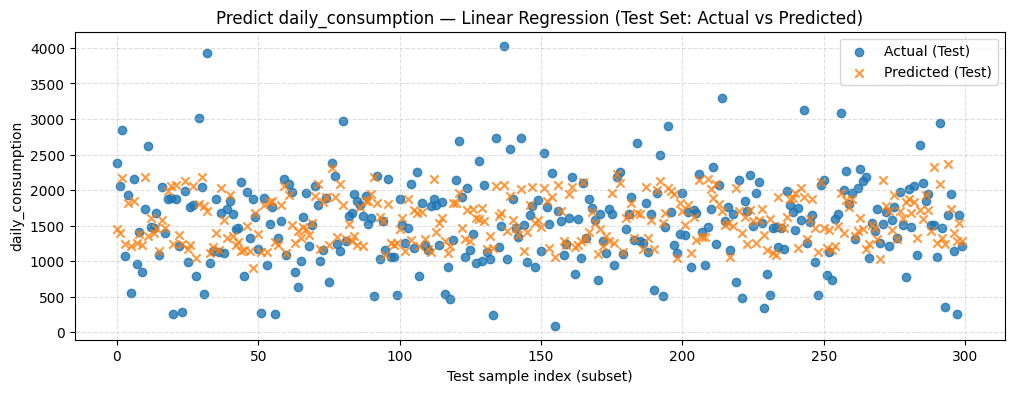


Scenario: Predict daily_consumption
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 2037.4142 (+165.5267) * AWND (-60.9740) * TMAX (-27.8962) * AWND^2 (+26.8325) * TMIN (-10.4820) * PRCP (-2.6130) * TMAX TMIN (-1.9368) * PRCP TMIN (+1.8505) * TMAX^2 (+1.5725) * PRCP TMAX (+1.2309) * AWND PRCP (+1.1693) * AWND TMIN (-1.0760) * AWND TMAX (+0.2939) * TMIN^2 (-0.0545) * PRCP^2


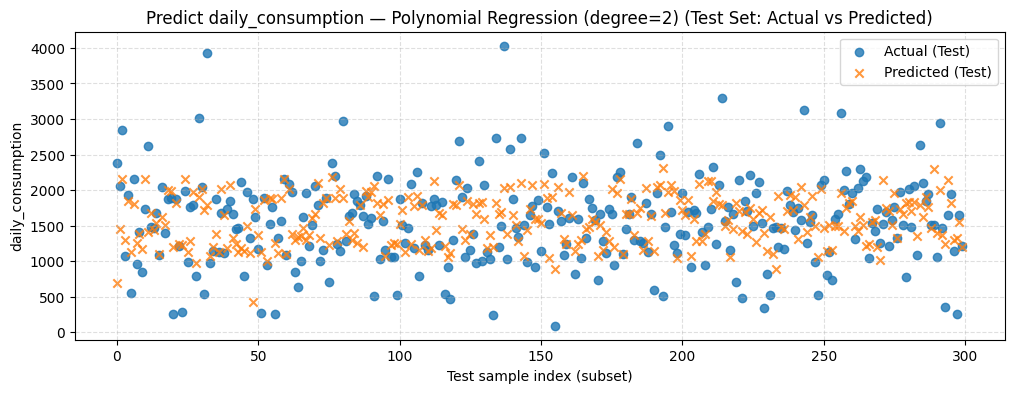


Scenario: Predict daily_consumption
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 1405.7630 (+509.9634) * AWND (-140.8094) * AWND^2 (+67.4216) * TMAX (-63.7983) * TMIN (+25.0565) * TMAX TMIN (-20.2281) * AWND TMIN (-13.9648) * TMIN^2 (-13.1044) * TMAX^2 (+9.3010) * PRCP (+7.8406) * AWND^3 (-4.9294) * AWND PRCP (+3.8559) * AWND^2 TMAX (+3.4853) * AWND TMAX TMIN (+2.2711) * AWND TMAX (-1.8669) * TMAX^2 TMIN
(Showing top 15 terms out of 34 total terms.)


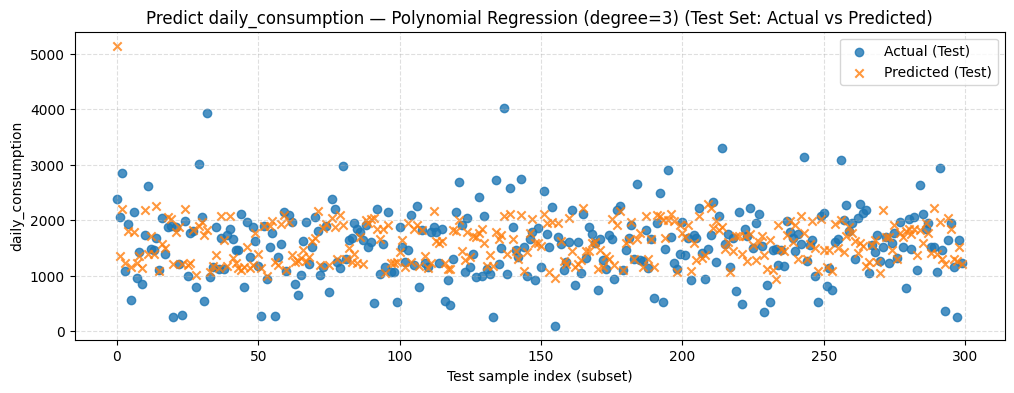


Scenario: Predict daily_consumption
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 1437.2413 (-416.4509) * AWND (-386.5721) * TMIN (+312.1157) * TMAX (+245.1996) * AWND^2 (+175.5947) * TMAX TMIN (+144.1717) * AWND TMAX (-110.1963) * AWND TMIN (-89.7729) * TMIN^2 (-83.0902) * AWND PRCP (-82.3475) * TMAX^2 (-63.0753) * AWND^2 TMAX (+58.6639) * AWND^2 TMIN (-41.9050) * AWND^3 (+26.1746) * AWND^2 PRCP (-25.1428) * AWND TMAX TMIN
(Showing top 15 terms out of 69 total terms.)


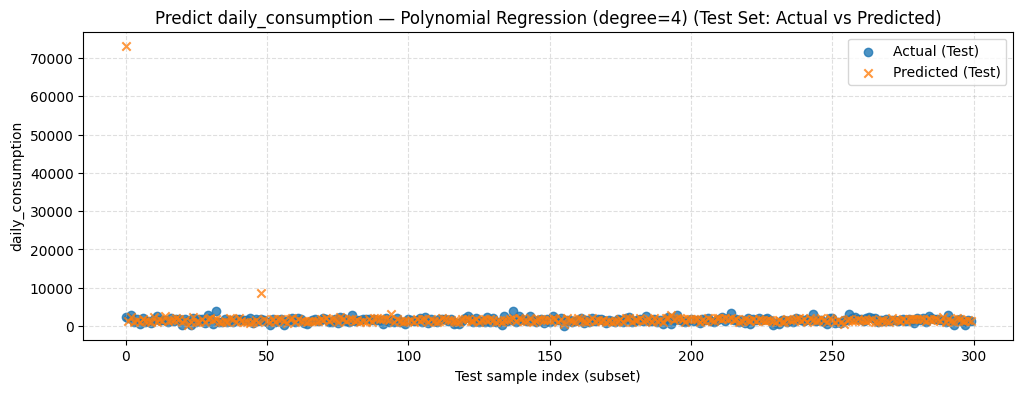

,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2
0,Predict daily_consumption,Linear Regression,272403.396174,384.465016,0.276000,2.481258e+05,375.404537,0.299333
1,Predict daily_consumption,Polynomial Regression (degree=2),264765.769932,379.648753,0.296300,2.552685e+05,379.039083,0.279163
2,Predict daily_consumption,Polynomial Regression (degree=3),259249.534870,375.952901,0.310961,2.656237e+05,385.235167,0.249922
3,Predict daily_consumption,Polynomial Regression (degree=4),251909.339001,372.116566,0.330470,1.215149e+07,578.642201,-33.313844


In [15]:
df_no_extra = df.drop(columns=[EXTRA_COL]).copy()

results = run_models_and_evaluate(
    df_no_extra,
    scenario_name="Predict daily_consumption",
    degrees=(1, 2, 3, 4),
    show_equation=True,
    show_plots=True,
    top_k_terms=15
)

display(results)

# 1.5 - Discussion and Interpretation

**Which model generalizes best (best test performance), and what does that tell you about the relationship between weather and electricity usage?**

The linear model has the best test performance, as it has the highest Test R2 value. This model has an R2 value of 0.299333, which means that the model expalins ~29.99333% of the variance in electricity usage.


**Do polynomial models improve the fit compared to linear regression? If yes, why might electricity consumption have nonlinear dependence on weather?**

No. The R2 value does not improve with an increase in polynomial degreee, meaning it did not improve the fit compared to linear regression.


**If higher-degree models perform worse on the test set, explain this behavior using evidence from metrics (e.g., train error decreases but test error increases).**

As the degree model increases, the Train MAE decreases whilst the Test MAE increases. Furthermore, the Test R2 value becomes negative for the fourth degree polynomial regression model, which is indicates overfitting.


**If none of the models achieve good test performance, provide at least two reasons supported by your outputs (e.g., limited feature set, high noise, unmodeled drivers such as occupancy/behavior,seasonal effects)**

The best R2 value out of all models is ~0.299333, which is not a good test performance at all. A big reason to this is limited feature set – the weather alone cannot predict electricity usage, as other factors such as economic standing, day of the week, month, etc. are key factors in predicting usage as well. Secondly, the date was removed to produce the regression. This unmodeled driver would have had a significant effect on electricity usage, as it connects to the temperature and month of year.